# Estimating the power spectrum with multiple grids

It can be useful if the grid of the desired resolution does not fit all into memory and multiple GPU nodes are not available or interconnect is slow.

In [1]:
from pathlib import Path

import numpy as np
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from jaxpower import (compute_mesh2_spectrum, Spectrum2Poles, generate_gaussian_mesh, generate_anisotropic_gaussian_mesh, generate_uniform_particles, RealMeshField, ParticleField, FKPField,
                      compute_fkp2_spectrum, BinnedStatistic, WindowMatrix, MeshAttrs, BinMesh2Spectrum, compute_mesh2_spectrum_mean, compute_mesh2_spectrum_window, compute_normalization, compute_fkp2_spectrum_normalization, compute_fkp2_spectrum_shotnoise, 
                      utils, create_sharding_mesh, make_particles_from_local, create_sharded_array, create_sharded_random)

attrs = MeshAttrs(meshsize=(128,) * 3, boxsize=1000., boxcenter=1200.)
size = int(1e-3 * attrs.boxsize.prod())

cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)

f, b = 0.8, 1.5
beta = f / b
kinedges = np.linspace(0.001, 0.7, 100)
kinedges = np.column_stack([kinedges[:-1], kinedges[1:]])
kin = np.mean(kinedges, axis=-1)
ells = (0, 2, 4)
poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk(kin),
                    0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk(kin),
                    8. / 35 * beta ** 2 * pk(kin)])
theory = BinnedStatistic(x=[kin] * len(ells), edges=[kinedges] * len(ells), value=poles, projs=ells)



In [2]:
def generate_mock(seed):
    if isinstance(seed, int):
        seed = jax.random.key(seed)
    seeds = jax.random.split(seed)
    data = generate_uniform_particles(attrs, size + 1, seed=seeds[0])
    randoms = generate_uniform_particles(attrs, 4 * size + 1, seed=seeds[1])
    mesh = generate_anisotropic_gaussian_mesh(attrs, theory, seed=seeds[2], los='local', unitary_amplitude=True)
    data = data.clone(weights=1. + mesh.read(data.positions))
    return FKPField(data, randoms, **attrs.clone(boxsize=2. * attrs.boxsize))  # x2 padding


# Generate mock
fkp = generate_mock(42)

# Compute power spectrum
norm = compute_fkp2_spectrum_normalization(fkp)
num_shotnoise = compute_fkp2_spectrum_shotnoise(fkp)
mesh = fkp.paint(resampler='tsc', interlacing=2, compensate=True, out='real')
bin = BinMesh2Spectrum(mesh.attrs, edges={'step': 0.01}, ells=(0, 2, 4))
poles = compute_mesh2_spectrum(mesh, bin=bin, los='firstpoint').clone(norm=norm, num_shotnoise=num_shotnoise)

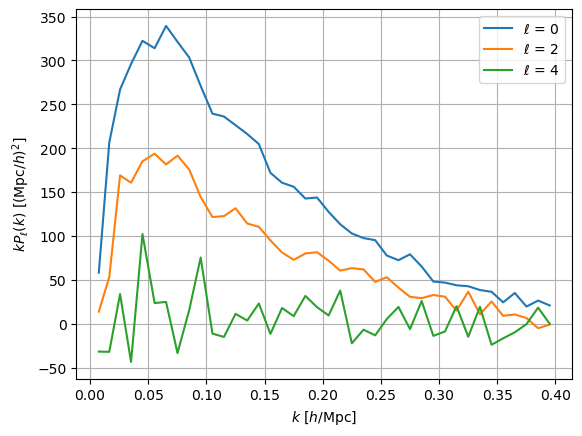

In [3]:
poles.plot(show=True);

In [4]:
# Compute multigrid power spectrum

list_poles = {}
edges = {'step': 0.01}

compute = jax.jit(compute_mesh2_spectrum, static_argnames=['los'])

for level, nsplits in enumerate([1, 2]):
    bin = None
    list_poles[level] = []
    for split_fkp in fkp.clone(meshsize=attrs.meshsize // 2).split(nsplits=nsplits):
        split_norm = compute_fkp2_spectrum_normalization(fkp)
        split_num_shotnoise = compute_fkp2_spectrum_shotnoise(fkp)
        mesh = split_fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
        # Compute mesh power spectrum
        if bin is None: bin = BinMesh2Spectrum(mesh.attrs, edges=edges, ells=(0, 2, 4))
        split_poles = compute(mesh, bin=bin, los='firstpoint').clone(norm=split_norm, num_shotnoise=split_num_shotnoise)
        list_poles[level].append(split_poles)

In [5]:
# Concatenate power spectrum estimates

fnyq = 0.8
split_poles = []
for level in list_poles:
    kmin = 0
    kmax = np.inf
    if level < len(list_poles) - 1: kmax = fnyq * list_poles[level][0].edges(projs=0).max()
    if split_poles: kmin = split_poles[-1].edges(projs=0).max()
    split_poles.append(list_poles[0][0].sum([poles.select(xlim=(kmin, kmax)) for poles in list_poles[level]]))
split_poles = split_poles[0].concatenate(split_poles)

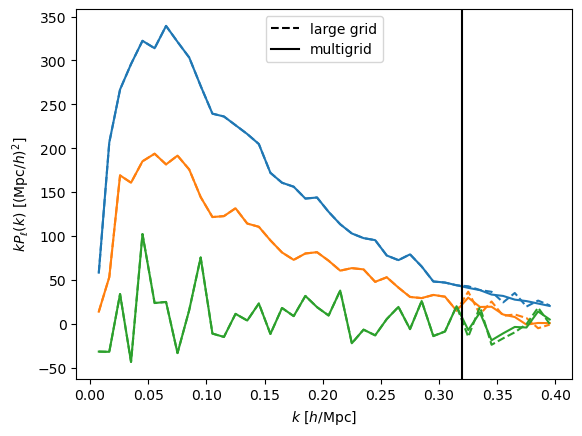

In [6]:
# Plot
ax = plt.gca()
for iproj, proj in enumerate(poles.projs):
    color = 'C{:d}'.format(iproj)
    k = poles.x(projs=proj)
    ax.plot(k, k * poles.view(projs=proj).real, linestyle='--', color=color)
    k = split_poles.x(projs=proj)
    ax.plot(k, k * split_poles.view(projs=proj).real, linestyle='-', color=color)
ax.plot([], [], color='k', linestyle='--', label='large grid')
ax.plot([], [], color='k', linestyle='-', label='multigrid')
ax.axvline(x=list_poles[0][0].edges(projs=0).max() * fnyq, color='k')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
plt.show()

Let's reorganize into one function!

In [7]:
def compute_power(fkp, nsplits=None):

    def compute_one(fkp, bin=None):
        norm = compute_fkp2_spectrum_normalization(fkp)
        num_shotnoise = compute_fkp2_spectrum_shotnoise(fkp)
        mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
        if bin is None: bin = BinMesh2Spectrum(mesh.attrs, edges=edges, ells=(0, 2, 4))
        toret = compute(mesh, bin=bin, los='firstpoint').clone(norm=norm, num_shotnoise=num_shotnoise), bin
        return toret

    if nsplits is None:  # no multigrid
        return compute_one(fkp)[0]

    # Compute multigrid power spectrum
    meshsize = fkp.attrs.meshsize // nsplits
    list_poles = {}
    for level, nsplits in enumerate([1, nsplits]):
        bin = None
        list_poles[level] = []
        for split_fkp in fkp.clone(meshsize=meshsize).split(nsplits=nsplits):
            split_poles, bin = compute_one(split_fkp, bin=bin)
            list_poles[level].append(split_poles)

    # Concatenate power spectrum estimates
    fnyq = 0.8
    split_poles, ksplits = [], []
    for level in list_poles:
        kmin = 0
        kmax = np.inf
        if level < len(list_poles) - 1: kmax = fnyq * list_poles[level][0].edges(projs=0).max()
        if split_poles: kmin = split_poles[-1].edges(projs=0).max()
        xlim = (kmin, kmax)
        ksplits.append(xlim)
        split_poles.append(list_poles[0][0].sum([poles.select(xlim=xlim) for poles in list_poles[level]]))
    poles = split_poles[0].concatenate(split_poles)
    poles.attrs['ksplits'] = ksplits
    return poles

In [8]:
poles = compute_power(fkp, nsplits=None)
split_poles = compute_power(fkp, nsplits=2)

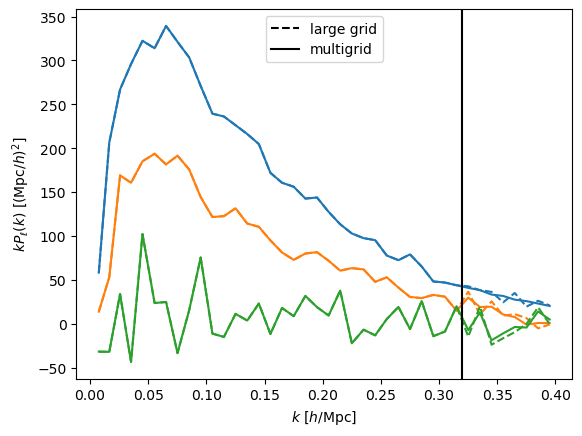

In [9]:
ax = plt.gca()
for iproj, proj in enumerate(poles.projs):
    color = 'C{:d}'.format(iproj)
    k = poles.x(projs=proj)
    ax.plot(k, k * poles.view(projs=proj).real, linestyle='--', color=color)
    k = split_poles.x(projs=proj)
    ax.plot(k, k * split_poles.view(projs=proj).real, linestyle='-', color=color)
ax.plot([], [], color='k', linestyle='--', label='large grid')
ax.plot([], [], color='k', linestyle='-', label='multigrid')
ax.axvline(x=split_poles.attrs['ksplits'][0][1], color='k')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
plt.show()